In [90]:
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

import plio
import numpy as np
from autocnet.cg import cg as util
from autocnet.examples import get_path
from autocnet.graph.network import CandidateGraph
from autocnet.graph.edge import Edge
from autocnet.matcher.feature import FlannMatcher
from scipy.spatial import Voronoi, voronoi_plot_2d
import pandas
from IPython.display import display

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [113]:
def voronoi(edge, node, clean_keys=[]):
    #node = {'destination':destination, 'source':source}
    if node == "destination":
#         matches, mask = edge.clean(clean_keys=clean_keys)
#         indices = pandas.Index(matches['destination_idx'].values)
        
        keypointsPd = edge.destination.get_keypoint_coordinates()
        convex_coords = edge.source.geodata.xy_corners
    else:
#         matches, mask = edge.clean(clean_keys=clean_keys)
#         indices = pandas.Index(matches['source_idx'].values)

        keypointsPd = edge.source.get_keypoint_coordinates()
        convex_coords = edge.destination.geodata.xy_corners

    keypoints = np.array(keypointsPd)
    print(keypointsPd)
    edges = np.array([[-50, -50], [-50, 1062], [1063, 1063], [1063, -50]])
    print(edges)
    keypoints = numpy.append(keypoints, edges, axis=0)
    print(keypoints)
    vor = Voronoi(keypoints, incremental = False) 
    
    polygon_array = []
    for region in vor.regions:
        if not -1 in region:
            polygon = [vor.vertices[i] for i in region]
            poly_points = np.array(polygon)
            #poly_hull = util.convex_hull(poly_points)
            convex_hull = util.convex_hull(convex_coords)
            #overlap = polygon.Intersection(convex_hull)
            polygon_array += polygon
    return vor

               x           y
0      52.284580  919.645752
1     850.199585  616.895630
2     850.199585  616.895630
3     143.227203  615.442932
4      65.558907  977.142517
5     873.004211  535.866272
6      81.621162  975.297363
7     394.985077  177.841431
8     873.004211  535.866272
9     874.446960  289.342010
10    874.446960  289.342010
11    549.801392  513.290222
12    493.088837  367.882416
13    639.075317  375.292480
14    274.875977  266.957672
15    274.875977  266.957672
16    526.406189  277.564728
17    852.296631  221.722519
18    852.296631  221.722519
19    857.383179  170.379425
20    176.063828  909.784790
21    363.850891  119.220970
22    858.120056  103.244385
23    381.803345  250.404617
24    258.111694  854.084290
25     32.522339   51.783314
26    830.867737  319.620880
27    361.772675   19.495415
28    712.766968  241.641937
29    723.677002  992.989990
..           ...         ...
470   533.069397  674.336670
471   720.421631  769.308655
472   955.9465

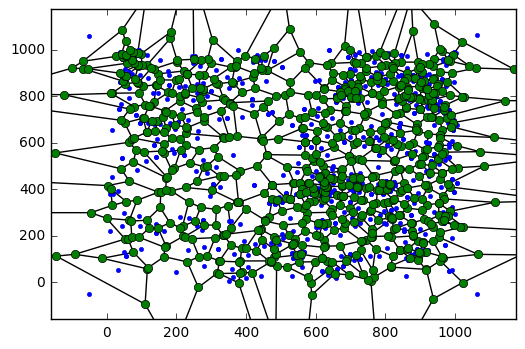

In [114]:
#Point to the adjacency Graph
adjacency = get_path('three_image_adjacency.json')
basepath = get_path('Apollo15')
cg = CandidateGraph.from_adjacency(adjacency, basepath=basepath)

#Apply SIFT to extract features
cg.extract_features(method='sift', extractor_parameters={'nfeatures':500})

#Match
cg.match_features()

#Apply outlier detection
cg.apply_func_to_edges(Edge.symmetry_check)
cg.apply_func_to_edges(Edge.ratio_check)
m = cg.edge[0][1].masks
cg.minimum_spanning_tree()

#Compute a homography and apply RANSAC
cg.apply_func_to_edges("compute_fundamental_matrix", clean_keys=['ratio', 'symmetry'])
extent = cg.edge[0][1].source.geodata.xy_extent

vor = voronoi(cg.edge[0][1], 'source', clean_keys = ['fundamental'])

#print(dir(vor))

voronoi_plot_2d(vor)
plt.show()

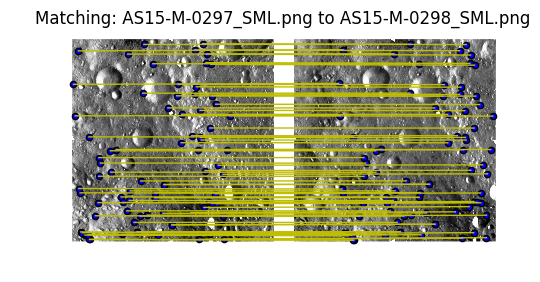

In [115]:
fig, ax = plt.subplots(1,1)
ax = cg.edge[0][1].plot(clean_keys=['ratio', 'symmetry', 'fundamental'], ax=ax)

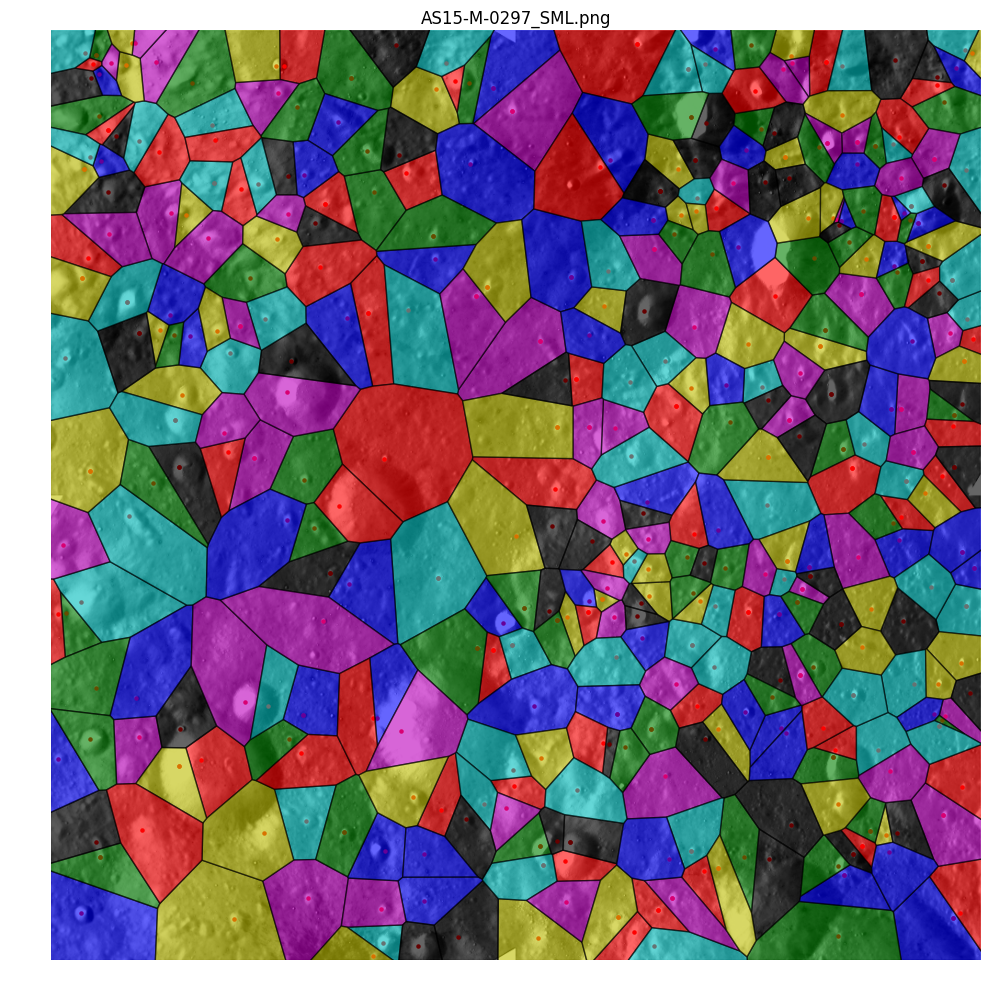

In [116]:
figure(num=None, figsize=(12, 12))
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha = .6)

plt.xlim(vor.min_bound[0] + 50, vor.max_bound[0] - 50)
plt.ylim(vor.min_bound[1] + 50, vor.max_bound[1] - 50)
# 
        
cg.edge[0][1].source.plot()
plt.show()

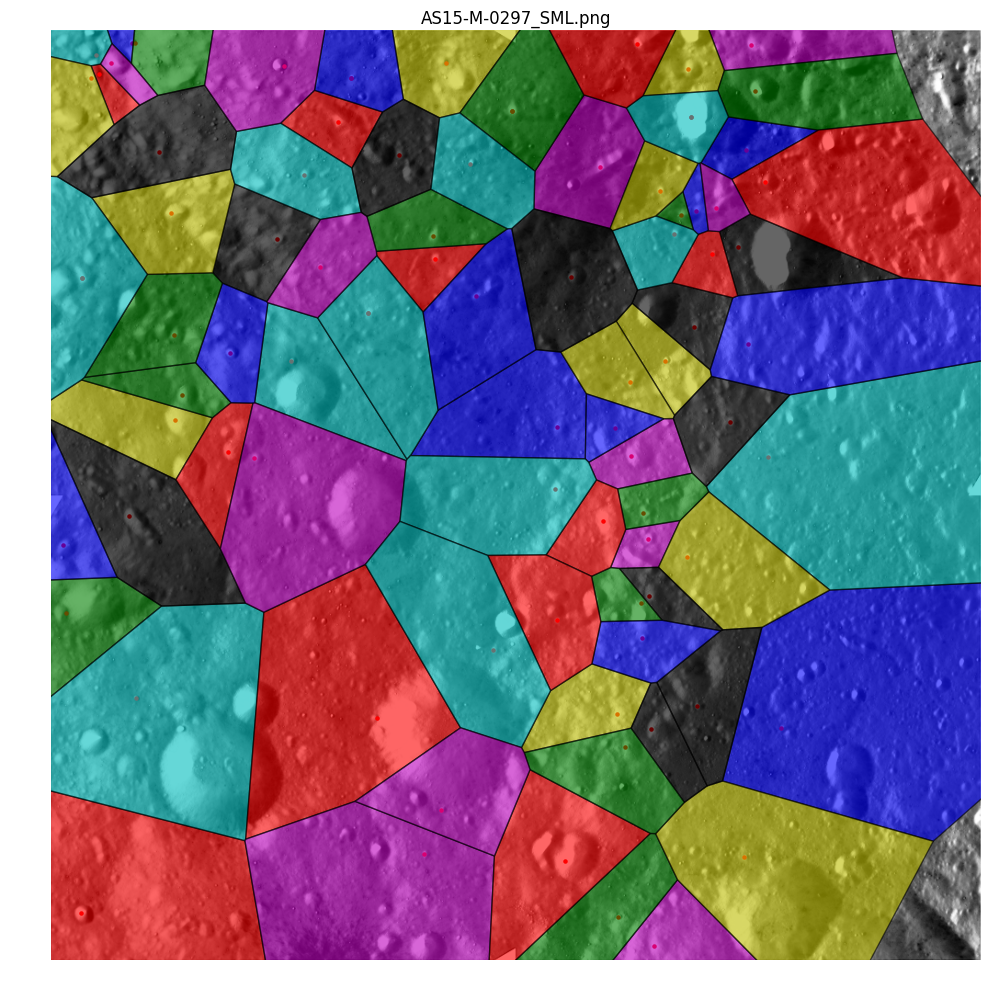

In [106]:
figure(num=None, figsize=(12, 12))
for region in vor.regions:
    if not -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha = .6)

plt.xlim(vor.min_bound[0] + 50, vor.max_bound[0] - 50)
plt.ylim(vor.min_bound[1] + 50, vor.max_bound[1] - 50)
# 

matches, mask = cg.edge[0][1].clean(clean_keys=['fundamental'])
indices = pandas.Index(matches['source_idx'].values)
        
cg.edge[0][1].source.plot(index_mask=indices)
plt.show()

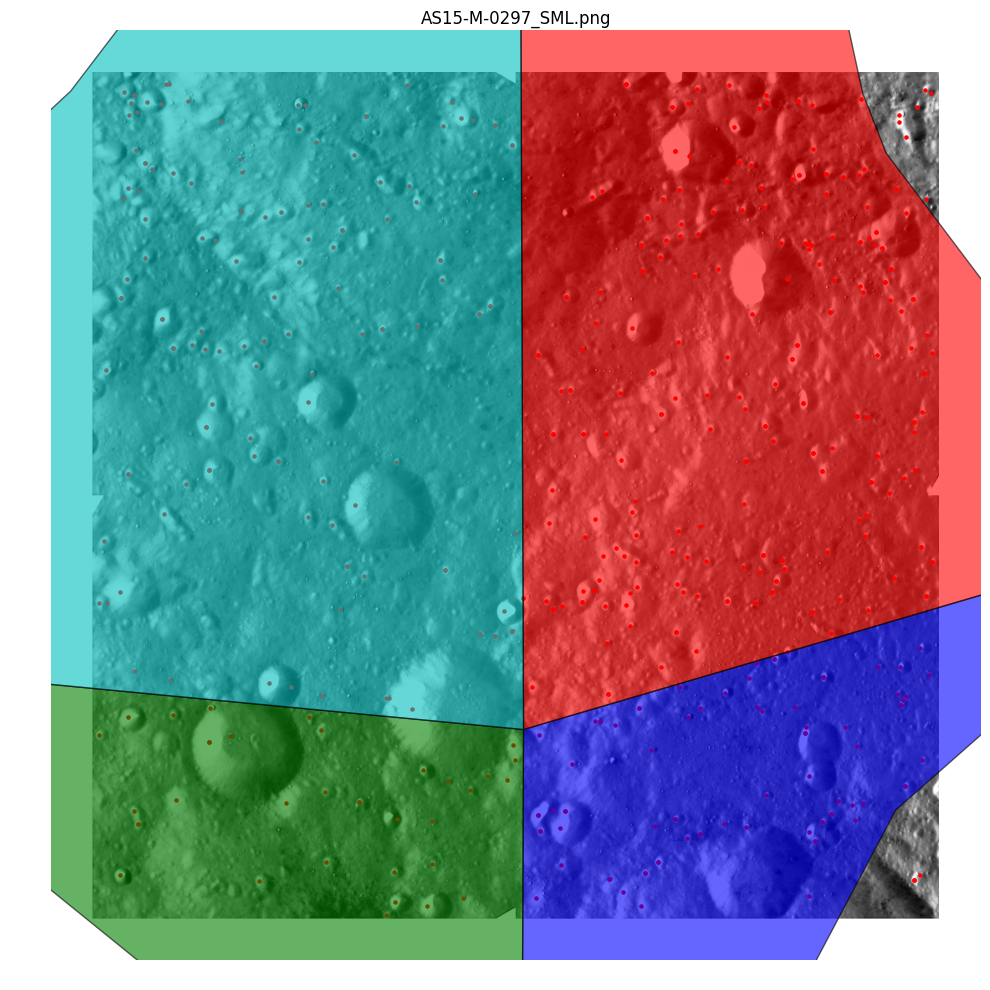

In [103]:
figure(num=None, figsize=(12, 12))
for region in vor.regions:
    if -1 in region:
        polygon = [vor.vertices[i] for i in region]
        plt.fill(*zip(*polygon), alpha = .6)

plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

cg.edge[0][1].source.plot()
plt.show()